In [2]:
import pandas as pd
import scipy
from scipy import stats

# Hypothesis: There is no significant difference between pageviews for health articles across categories of high, medium, low, and unknown levels of importance.

Initially, the idea was to use the classifier I built and label the unknown-importance articles. However, since the accuracy is not high enough, it is dangerous to manipulate data like that, so I will only use the data I have for certain.

# Step 1: Load data and determine which variables you're using.

In [59]:
df = pd.read_csv('unique_health_articles.csv')

In [60]:
df.head()

,Unnamed: 0,article,qid,total_pageviews,description,category,page_size,incoming_links,outgoing_links,num_editors,article_age,total_revisions,total_translations,unique_days_viewed
0,0,1977_NestlÃ©_boycott,Q1498774,27259,boycott,Low-importance,NaN,0,0,0,NaN,NaN,0,74
1,1,2007_tuberculosis_scare,Q4609852,550,international health scare,Low-importance,16565.0,41,83,291,6771.0,16565.0,0,1
2,2,2011_United_States_listeriosis_outbreak,Q4622783,871,disease outbreak in the United States,Low-importance,23708.0,228,305,85,5190.0,23708.0,1,4
3,3,2014_California_Proposition_46,Q119129906,153,NaN,Low-importance,5373.0,957,1046,11,936.0,5373.0,1,1
4,4,24_Hour_Fitness,Q4631849,1122,US fitness center chain,Low-importance,21019.0,88,88,484,7116.0,21019.0,0,7


In [62]:
df.sort_values(by='total_pageviews', ascending=False)

,Unnamed: 0,article,qid,total_pageviews,description,category,page_size,incoming_links,outgoing_links,num_editors,article_age,total_revisions,total_translations,unique_days_viewed
676,676,Richard_Simmons,Q498019,2949687,American fitness instructor and video producer...,Unknown-importance,82448.0,191,449,2451,8430.0,82448.0,82,731
241,241,Enteritis,Q854353,1523654,intestinal inflammatory disease,Mid-importance,19257.0,390,367,117,7944.0,19257.0,28,516
60,60,Average_human_height_by_country,Q16128414,1345672,Wikimedia list article,Low-importance,167046.0,18,728,938,5054.0,167046.0,9,731
684,684,Sackler_family,Q61911512,1224161,American billionaire family,Low-importance,53256.0,74,248,393,2486.0,53256.0,13,731
478,478,Maslow's_hierarchy_of_needs,Q179515,1219581,theory in developmental psychology proposed by...,Unknown-importance,46766.0,788,419,2917,8383.0,46766.0,65,731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,378,Home_care,Q1642542,91,health care or supportive care provided by a p...,Unknown-importance,6151.0,249,77,76,2438.0,6151.0,19,1
609,609,Physical_strength,Q1785966,91,measure of a life form's exertion of force on ...,Low-importance,4971.0,198,36,405,7830.0,4971.0,23,1
624,624,Primary_health_care,Q623543,90,essential health care accessible to all indivi...,High-importance,22026.0,186,183,265,7409.0,22026.0,17,1
190,190,Decriminalization_of_sex_work,Q17001582,90,removal of criminal penalties for sex work,Low-importance,91810.0,405,605,122,4373.0,91810.0,9,1


In [63]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.tail()

,article,qid,total_pageviews,description,category,page_size,incoming_links,outgoing_links,num_editors,article_age,total_revisions,total_translations,unique_days_viewed
878,Yoga_as_exercise,Q65091595,4324,physical activity consisting mainly of yoga poses,High-importance,105306.0,787,1178,167,2534.0,105306.0,9,42
879,Young_Living,Q18067581,2947,American multi-level marketing company,Low-importance,23704.0,103,179,178,4204.0,23704.0,3,28
880,Zero_emission_zone,Q647266,127,defined area,High-importance,59.0,1,6,1,502.0,59.0,0,2
881,Zumba,Q229680,42089,dance fitness program,Mid-importance,22096.0,154,142,906,7250.0,22096.0,37,333
882,Zyzz,Q2618609,181047,Russian-born Australian bodybuilder and Intern...,Mid-importance,24173.0,23,114,291,5232.0,24173.0,22,695


The x variable is article of SOME level of importance (category), and the y variable is total_pageviews.

In [64]:
df.groupby('category')['total_pageviews'].mean()

category
High-importance       86956.530435
Low-importance        30896.722458
Mid-importance        63192.496933
Unknown-importance    58540.090226
Name: total_pageviews, dtype: float64

In [65]:
high = df[df['category'] == 'High-importance']
mid = df[df['category'] == 'Mid-importance']
low = df[df['category'] == 'Low-importance']
unknown = df[df['category'] == 'Unknown-importance']

In [66]:
high_low = pd.concat([high, low], axis=0)

# Step 2: Testing the hypothesis using pairwise T-tests and ANOVA.

Null hypothesis: Average pageviews in high, medium, low, and unknown levels of importance are the same.
Alternative hhypothesis: [...] are not the same.

In [67]:
t_stat, p_val = stats.ttest_ind(high['total_pageviews'], low['total_pageviews'], equal_var=False)
print(t_stat)
print(p_val)

3.6249523087387217
0.0003984909073003995


In [68]:
t_stat2, p_val2 = stats.ttest_ind(mid['total_pageviews'], low['total_pageviews'], equal_var=False)
print(t_stat2)
print(p_val2)

2.3600331181994205
0.01913900715709955


In [69]:
for category in df['category'].unique():
    print(category, len(df[df['category'] == category]['total_pageviews'].dropna()))

Low-importance 472
High-importance 115
Unknown-importance 133
Mid-importance 163


Since I want to compare all levels of importance with each other, using ANOVA is more productive.

In [70]:
groups = []
for category in df['category'].unique():
    groups.append(df[df['category'] == category]['total_pageviews'].dropna())

f_stat, p_val = stats.f_oneway(*groups)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4f}")

F-statistic: 4.3961
P-value: 0.0044


In [71]:
# Full ANOVA table using statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

danova = ols('total_pageviews ~ C(category)', data=df).fit()
# Get the ANOVA table
anova_table = sm.stats.anova_lm(danova, typ=2)
print(anova_table)

                   sum_sq     df         F   PR(>F)
C(category)  3.649012e+11    3.0  4.396129  0.00443
Residual     2.432050e+13  879.0       NaN      NaN


# Step 3: Visualizations: boxplots.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

I need to normalize my data first because the pageviews data is very spread out.

In [31]:
import numpy as np
df['total_pageviews_log'] = np.log1p(df['total_pageviews'])

/var/folders/f6/71_23hqx2gv3g0x_h49kbbf80000gn/T/ipykernel_27515/1834722999.py:1: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x="category", y="total_pageviews_log",


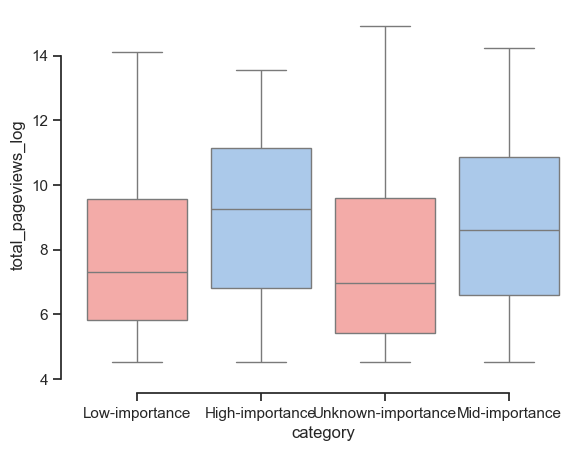

In [32]:
sns.boxplot(x="category", y="total_pageviews_log",
            hue="category", palette=["r", "b"],
            data=df)
sns.despine(offset=10, trim=True)

<Axes: >

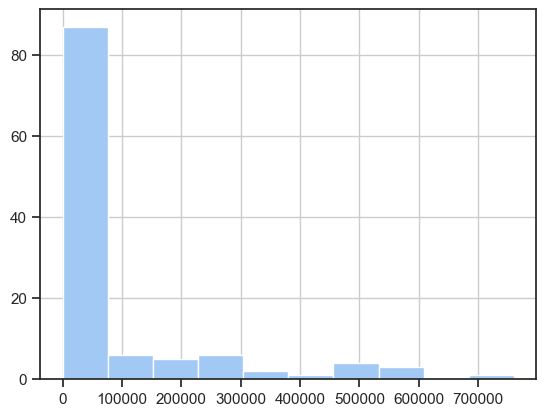

In [34]:
high['total_pageviews'].hist()

<Axes: >

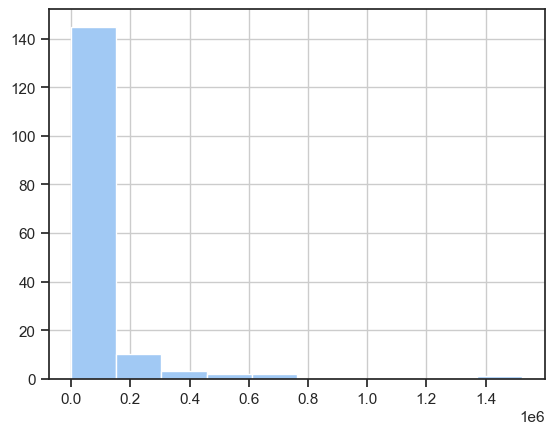

In [36]:
mid['total_pageviews'].hist()

<Axes: >

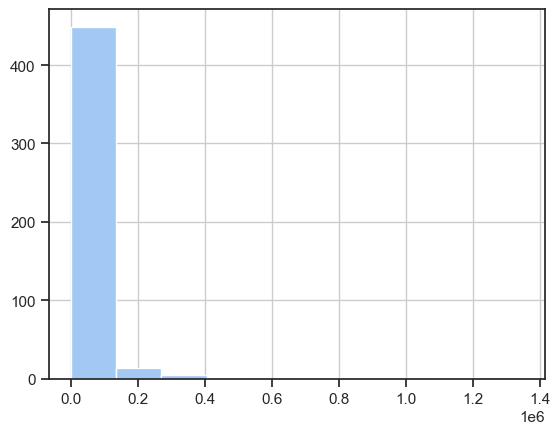

In [37]:
low['total_pageviews'].hist()